In [1]:
%run -i "loaddata.py"
plt.style.use('seaborn-white')
plt.style.use('seaborn-ticks')
plt.rcParams["font.size"] = 13
import scipy.stats as st
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
np.random.seed(42)

What is your name? [Simone/Jonathan/Marcus/Runi]Jonathan


In [2]:
# Choose wisely
save = False
only_2_features=False
test_on = 0
scale = True

In [3]:
# Collect all data into 1 array
keys = tuple(data_dict.keys())[::2]

data = []
for key in keys:
    for vec in list(data_dict[key]):
        if not np.isnan(vec[0]) and (vec[:][3:]!=0).any():
            data.append(vec)
data = np.array(data)
print(data.shape)
features = data_dict[ list(data_dict.keys())[1] ]

(1568, 28)


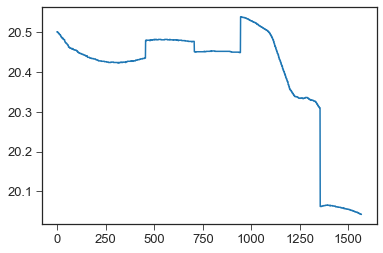

In [4]:
features[8], features[14]
plt.plot(data[:,8])

# All time series in a single plot

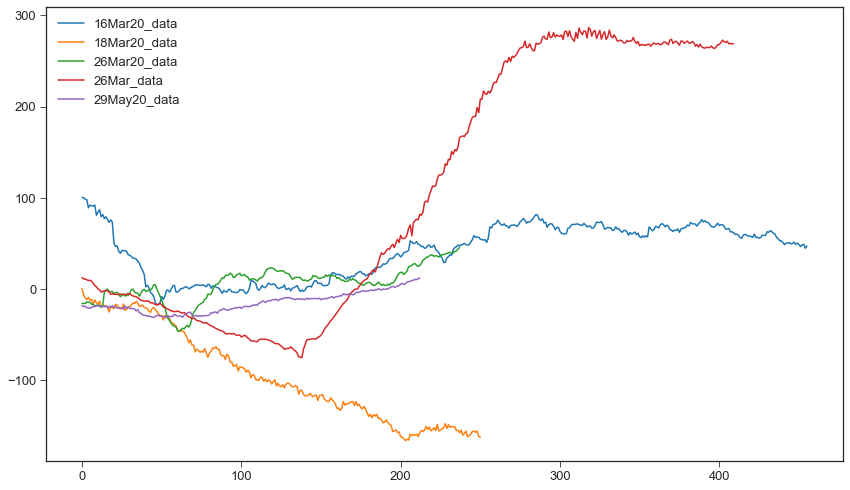

In [5]:
lengths = [len(data_dict[keys[i]]) for i in range(len(keys))]

plt.figure(figsize=(12,7))
for key in keys:
    plot_data = data_dict[key][:,1]
    plot_data = plot_data[np.isnan(plot_data) != True]
    plt.plot(plot_data, label=key)
plt.legend()
plt.tight_layout()
plt.show()

# sklearn time
## XGBoost

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data[:,3:], data[:,1], test_size=0.25)

model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

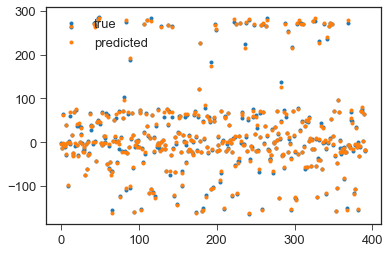

RMS = 3.074


In [7]:
plt.figure()
plt.plot(y_test, '.',label="true")
plt.plot(y_pred, '.', label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### New Split Shit

In [8]:
# 50/50 split
X_train, X_test = np.copy(data[ ::2, 3:]), np.copy(data[1::2, 3:])
y_train, y_test = np.copy(data[ ::2, 1 ]), np.copy(data[1::2, 1 ])

model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

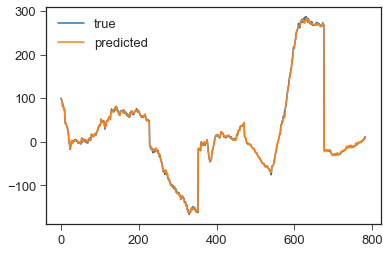

RMS = 2.654


In [9]:
plt.figure()
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### Predict 1 timeseries

In [10]:
# Clean and put into data_sort
data_sort = []
for key in keys:
    pre_data = []
    for i in range( len(data_dict[key]) ):
        if ( (data_dict[key][i,3:] != 0.).all() ) & ( (np.isnan(data_dict[key][i, :])!=True).all() ):
            pre_data.append( list(data_dict[key][i,:]) )
    data_sort.append(np.array(pre_data))
print("Shapes of different timeseries:",[i.shape for i in data_sort])

def test_1_timeseries( test_index , scaler=False):
    X_train = np.empty(( 0, data_sort[0].shape[1]-3))
    y_train = np.array([])
    for i in range(len(data_sort)):
        if i!=test_index:
            if scaler:
                scaler = StandardScaler()
                data_scaled = scaler.fit_transform(data_sort[i])
            else:
                data_scaled = data_sort[i]
            X_train = np.append(X_train, data_scaled[:,3:], axis=0)
            y_train = np.append(y_train, data_scaled[:,1])
    if scaler:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data_sort[test_index])
    else: 
        data_scaled = data_sort[test_index]
    X_test = data_scaled[:,3:]
    y_test = data_scaled[:,1]
    return X_train, X_test, y_train, y_test

Shapes of different timeseries: [(456, 28), (247, 28), (238, 28), (407, 28), (211, 28)]


(1103, 25) (456, 25) (1103,) (456,)


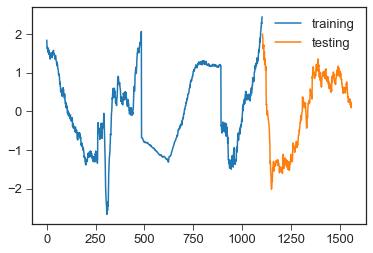

In [11]:
X_train, X_test, y_train, y_test = test_1_timeseries(test_on, scaler=scale)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# # Only two features
if only_2_features:
    X_train, X_test = X_train[:, [8-3, 14-3]], X_test[:, [8-3, 14-3]]
    print(X_train.shape, X_test.shape)

# Print figure
plt.figure()
x0 = np.arange(0, len(y_train),1)
x1 = np.arange(len(y_train), len(y_train)+len(y_test),1)
plt.plot(x0, y_train,label="training")
plt.plot(x1, y_test, label="testing")
plt.legend()
plt.show()

### XGboost

In [12]:
# Fit
mlp = xgb.XGBRegressor()
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

In [13]:
# Create a model with no hyperparameters
clf_xgb = xgb.XGBRegressor(random_state = 42, n_jobs=4)

# Parameters to search
parameters_RandomSearch = {
    "n_estimators": st.randint(1,20),
    "max_depth": st.randint(1,20),
    "learning_rate": st.uniform()
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_xgb, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=42,
                                  verbose = 1, 
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error')

# fit the random search instance
RandomSearch.fit(X_train, y_train)

# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.4s


Random Search: 	Best parameters:  {'learning_rate': 0.3854165025399161, 'max_depth': 2, 'n_estimators': 15} , Best scores: -0.8056


[Parallel(n_jobs=-1)]: Done 493 out of 500 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.3s finished


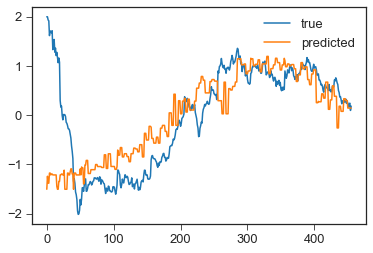

RMS = 0.765


In [14]:
y_pred = RandomSearch.predict(X_test)

plt.figure()
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### Bayesian Optimization

In [15]:
from bayes_opt import BayesianOptimization
def xgboost_CrossValidation(num_round, eta, max_depth, data, targets):
    """Decision Tree cross validation.
       Fits a Decision Tree with the given paramaters to the target 
       given data, calculated a CV accuracy score and returns the mean.
       The goal is to find combinations of max_depth, min_samples_leaf 
       that maximize the accuracy
    """
    
    estimator = xgb.XGBRegressor(random_state=42, 
                                  num_round=num_round,
                                  eta=eta,
                                  max_depth=max_depth)
    
    cval = cross_val_score(estimator, data, targets, cv=5)
    
    return cval.mean()

def optimize_xgboost(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to Decision Tree parameters."""
    
    def crossval_wrapper(num_round, eta, max_depth, data=data, targets=targets):
        """Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, min_samples_leaf 
           are casted to integer before we pass them along.
        """
        return xgboost_CrossValidation(max_depth=int(max_depth), 
                                       num_round=int(num_round),
                                       eta=eta,
                                       data=data, 
                                       targets=targets)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=42, 
                                     verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

In [16]:
parameters_BayesianOptimization = {"max_depth": (1, 20), 
                                   "num_round": (1, 20),
                                   "eta": (0,1)
                                  }

BayesianOptimization = optimize_xgboost(data = X_train, 
                                        targets = y_train, 
                                        pars = parameters_BayesianOptimization, 
                                        n_iter=200)
print(BayesianOptimization.max)

|   iter    |  target   |    eta    | max_depth | num_round |
-------------------------------------------------------------
|  1        | -0.1194   |  0.3745   |  19.06    |  14.91    |
|  2        | -0.1047   |  0.5987   |  3.964    |  3.964    |
|  3        |  0.0597   |  0.05808  |  17.46    |  12.42    |
|  4        | -0.08736  |  0.7081   |  1.391    |  19.43    |
|  5        | -0.1646   |  1.0      |  20.0     |  1.0      |
|  6        | -0.1693   |  1.0      |  9.418    |  13.24    |
|  7        | -0.5696   |  0.0      |  11.48    |  1.0      |
|  8        | -0.5696   |  0.0      |  1.0      |  10.83    |
|  9        | -0.5641   |  3.659e-0 |  11.83    |  19.93    |
|  10       | -0.4414   |  1.0      |  1.0      |  1.0      |
|  11       | -0.1646   |  1.0      |  20.0     |  7.865    |
|  12       | -0.1694   |  1.0      |  12.49    |  8.149    |
|  13       | -0.1567   |  1.0      |  14.85    |  13.41    |
|  14       | -0.5696   |  0.0      |  7.346    |  8.057    |
|  15   

|  81       | -0.5696   |  0.0      |  20.0     |  2.668    |
|  82       | -0.1609   |  1.0      |  18.44    |  11.38    |
|  83       | -0.2062   |  0.9801   |  19.76    |  6.152    |
|  84       | -0.5696   |  0.0      |  17.21    |  8.825    |
|  85       | -0.3735   |  0.9963   |  4.402    |  12.5     |
|  86       |  0.05961  |  0.01851  |  18.88    |  16.49    |
|  87       | -0.2927   |  0.9547   |  8.569    |  1.009    |
|  88       |  0.06682  |  0.05478  |  9.122    |  3.398    |
|  89       | -0.5696   |  0.0      |  17.65    |  20.0     |
|  90       | -0.1609   |  1.0      |  18.21    |  16.08    |
|  91       | -0.1516   |  1.0      |  11.76    |  10.38    |
|  92       | -0.5696   |  0.0      |  1.0      |  14.74    |
|  93       |  0.06811  |  0.04294  |  9.505    |  11.57    |
|  94       |  0.04955  |  0.04245  |  11.15    |  3.611    |
|  95       | -0.1637   |  1.0      |  10.01    |  20.0     |
|  96       | -0.1614   |  0.9844   |  7.505    |  17.97    |
|  97   

|  162      |  0.05764  |  0.03247  |  14.6     |  8.668    |
|  163      | -0.4372   |  1.0      |  3.265    |  1.0      |
|  164      |  0.03926  |  0.1156   |  12.83    |  9.053    |
|  165      |  0.0475   |  0.05327  |  10.06    |  4.302    |
|  166      | -0.1639   |  1.0      |  13.74    |  3.786    |
|  167      | -0.1399   |  0.9849   |  5.887    |  16.09    |
|  168      | -0.5696   |  0.0      |  4.303    |  13.68    |
|  169      | -0.5696   |  0.0      |  6.042    |  14.89    |
|  170      |  0.1217   |  0.03377  |  4.649    |  15.81    |
|  171      | -0.1614   |  0.9735   |  7.027    |  12.49    |
|  172      | -0.2346   |  0.9989   |  5.624    |  10.81    |
|  173      | -0.1934   |  1.0      |  6.732    |  7.245    |
|  174      | -0.1475   |  0.9907   |  19.98    |  9.582    |
|  175      | -0.1893   |  0.9879   |  16.75    |  2.294    |
|  176      | -0.5696   |  0.0      |  1.0      |  12.67    |
|  177      | -0.5696   |  0.0      |  12.7     |  3.167    |
|  178  

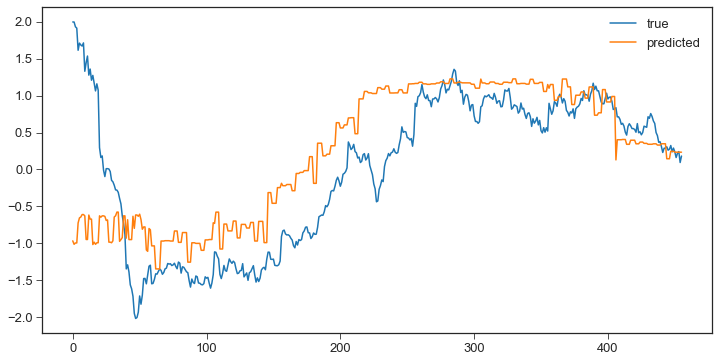

RMS = 0.737


In [17]:
model = xgb.XGBRegressor(eta = BayesianOptimization.max["params"]["eta"],
                          max_depth =int(BayesianOptimization.max["params"]["max_depth"]),
                          num_round = int(BayesianOptimization.max["params"]["num_round"]), 
                          random_state=42)

model.fit(X_train, y_train)

# make predictions for test data
y_pred_xg = model.predict(X_test)#+155

# evaluate predictions
plt.figure(figsize=(12,6))
plt.plot(y_test,label="true")
plt.plot(y_pred_xg, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred_xg)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

## NN

In [18]:
# 50/50 split
X_train, X_test = np.copy(data[ ::2, 3:]), np.copy(data[1::2, 3:])
y_train, y_test = np.copy(data[ ::2, 1 ]), np.copy(data[1::2, 1 ])

# Scale in order to 
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

In [19]:
mlp = MLPRegressor(hidden_layer_sizes=(15, 14), max_iter=2000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


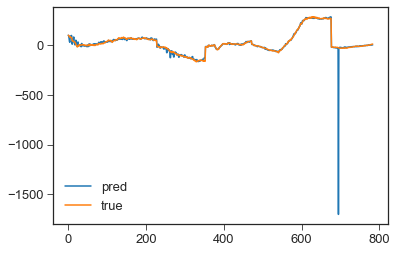

In [20]:
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

### CV random search

In [21]:
# Create a model with no hyperparameters
clf_NN = MLPRegressor(learning_rate = 'adaptive', solver='adam', early_stopping=True, max_iter=1000)

class hidden_layer:
    def __init__(self, min_range, max_range, max_layers=2):
        self.max_layers = max_layers
        self.min_range = min_range
        self.max_range = max_range
    
    def rvs(self,random_state):
        self.layers = np.random.randint(1,self.max_layers+1)
        sizes = []
        for i in range(self.layers):
            if i==0:
                sizes.append( np.random.randint(self.min_range, self.max_range) )
            elif sizes[i-1]==1:
                sizes.append( 1 )
            else:
                sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
        return tuple(sizes)

# Parameters to search
parameters_RandomSearch = {
    "activation": ["relu"],#, "logistic", "tanh"],
    "hidden_layer_sizes": hidden_layer(1, 100, max_layers=3),
    "learning_rate_init": st.uniform()
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_NN, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=42,
                                  verbose = 1, 
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error')

# fit the random search instance
RandomSearch.fit(X_train, y_train);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   34.7s finished


In [22]:
# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (14, 13), 'learning_rate_init': 0.9507143064099162} , Best scores: -65.7152


98.72825080408685


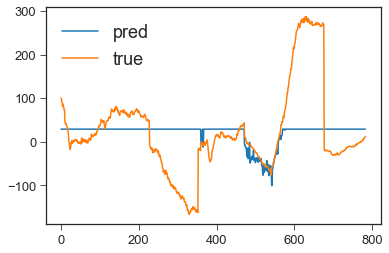

In [23]:
y_pred = RandomSearch.predict(X_test)
rms = np.sqrt(np.sum((y_pred-y_test)**2)/len(y_test))
print(rms)
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend(fontsize=(18))
plt.show()

### Predict one timeseries

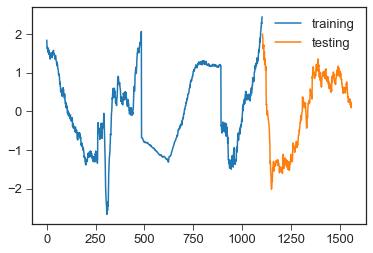

In [24]:
X_train, X_test, y_train, y_test = test_1_timeseries(test_on, scaler=scale)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Remove to only 2 features
if only_2_features:
    X_train, X_test = X_train[:, [8-3, 14-3]], X_test[:, [8-3, 14-3]]

# Plot
plt.figure()
x0 = np.arange(0, len(y_train),1)
x1 = np.arange(len(y_train), len(y_train)+len(y_test),1)
plt.plot(x0, y_train,label="training")
plt.plot(x1, y_test, label="testing")
plt.legend()
plt.show()

In [25]:
# Fit
mlp = MLPRegressor(hidden_layer_sizes=(24,23), max_iter=2000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

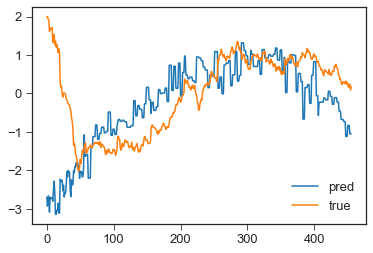

In [26]:
# Plotting
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

### CV

In [27]:
# Create a model with no hyperparameters
clf_NN = MLPRegressor(random_state=42, learning_rate = 'adaptive', solver='adam', early_stopping=True)

class hidden_layer:
    def __init__(self, min_range, max_range, max_layers=2):
        self.max_layers = max_layers
        self.min_range = min_range
        self.max_range = max_range
    
    def rvs(self,random_state):
        self.layers = np.random.randint(1,self.max_layers+1)
        sizes = []
        for i in range(self.layers):
            if i==0:
                sizes.append( np.random.randint(self.min_range, self.max_range) )
            elif sizes[i-1]==1:
                sizes.append( 1 )
            else:
                sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
        return tuple(sizes)

# Parameters to search
parameters_RandomSearch = {
    "activation": ["relu"],#, "logistic", "tanh"],
    "hidden_layer_sizes": hidden_layer(1, 100, max_layers=3),
    "learning_rate_init": st.uniform(),
#     "max_iter": st.randint(100,1000)
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_NN, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=42,
                                  verbose = 1, 
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error')

# fit the random search instance
RandomSearch.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   43.1s finished


In [28]:
# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (57, 37, 4), 'learning_rate_init': 0.034388521115218396} , Best scores: -0.7251


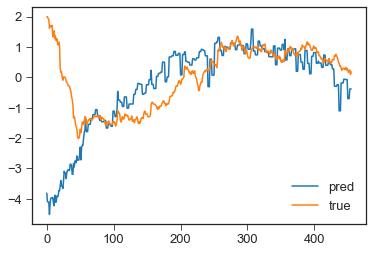

In [29]:
y_pred = RandomSearch.predict(X_test)
rms = np.sqrt(np.sum((y_pred-y_test)**2)/len(y_test))
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

### Bayesian optimization NN

In [30]:
from bayes_opt import BayesianOptimization
def NN_CrossValidation(learning_rate_init, nodes_1, nodes_2, data, targets):
    '''nodes contain the given number of nodes in the given layer'''
    estimator = MLPRegressor(random_state=42, learning_rate = 'adaptive', solver='adam', early_stopping=True, max_iter=1000,
                             learning_rate_init=learning_rate_init,
                             hidden_layer_sizes = (nodes_1, nodes_2))
    
    cval = cross_val_score(estimator, data, targets, cv=5)
    
    return cval.mean()

def optimize_NN(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to Decision Tree parameters."""
    
    def crossval_wrapper(learning_rate_init, nodes_1, nodes_2, data=data, targets=targets):
        """Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, min_samples_leaf 
           are casted to integer before we pass them along.
        """
        return NN_CrossValidation(learning_rate_init=learning_rate_init, 
                                       nodes_1 = int(nodes_1),
                                       nodes_2 = int(nodes_2),
                                       data=data, 
                                       targets=targets)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=42, 
                                     verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

In [31]:
parameters_BayesianOptimization = {"learning_rate_init": (0.0001, 1), 
                                   "nodes_1": (1, 100),
                                   "nodes_2": (1, 100)
                                  }

BayesianOptimization = optimize_NN(data = X_train, 
                                        targets = y_train, 
                                        pars = parameters_BayesianOptimization, 
                                        n_iter=100)
print(BayesianOptimization.max)

|   iter    |  target   | learni... |  nodes_1  |  nodes_2  |
-------------------------------------------------------------
|  1        | -4.533    |  0.3746   |  95.12    |  73.47    |
|  2        | -0.6359   |  0.5987   |  16.45    |  16.44    |
|  3        |  0.01895  |  0.05818  |  86.75    |  60.51    |
|  4        | -85.98    |  0.7081   |  3.038    |  97.02    |
|  5        | -0.2109   |  0.1291   |  88.87    |  63.14    |
|  6        |  0.1971   |  0.05557  |  85.42    |  62.5     |


C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  7        | -2.959e+0 |  1.0      |  85.55    |  62.32    |
|  8        | -24.28    |  0.943    |  37.42    |  22.91    |
|  9        | -3.524e+0 |  0.8941   |  86.29    |  41.91    |
|  10       | -19.04    |  0.3324   |  68.31    |  96.34    |
|  11       | -0.1292   |  0.09452  |  80.33    |  59.97    |
|  12       | -62.17    |  0.4031   |  84.23    |  76.0     |
|  13       | -4.577    |  0.6104   |  22.92    |  97.64    |
|  14       | -0.3779   |  0.04096  |  49.4     |  59.57    |
|  15       | -17.77    |  0.3084   |  86.25    |  10.29    |


C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  16       | -1.055e+0 |  0.8304   |  64.29    |  46.31    |
|  17       | -5.525    |  0.2683   |  26.27    |  50.94    |
|  18       | -386.4    |  0.6124   |  7.09     |  43.06    |
|  19       | -2.572    |  0.5924   |  72.24    |  13.67    |
|  20       | -90.1     |  0.9457   |  45.69    |  91.12    |
|  21       | -0.8557   |  0.6806   |  36.03    |  15.27    |
|  22       | -0.3807   |  0.3364   |  6.755    |  87.97    |
|  23       | -376.8    |  0.8803   |  83.93    |  32.76    |
|  24       | -20.21    |  0.3292   |  96.34    |  51.02    |
|  25       | -1.622    |  0.7689   |  9.082    |  64.2     |
|  26       | -12.67    |  0.5268   |  22.9     |  93.65    |
|  27       |  0.1143   |  0.07042  |  78.29    |  87.38    |
|  28       | -0.5004   |  0.1915   |  42.65    |  88.47    |
|  29       | -2.726    |  0.617    |  5.663    |  84.6     |
|  30       | -1.925e+0 |  0.8133   |  76.33    |  65.86    |
|  31       | -0.4107   |  0.2285   |  24.6     |  16.57    |
|  32   

C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  39       | -2.39e+03 |  0.7339   |  99.68    |  45.53    |
|  40       | -3.603e+0 |  0.7787   |  32.56    |  40.8     |
|  41       | -0.8181   |  0.7669   |  23.09    |  21.3     |
|  42       | -52.18    |  0.4883   |  80.33    |  87.7     |
|  43       | -5.001    |  0.5448   |  39.26    |  12.21    |
|  44       | -1.821e+0 |  0.7444   |  35.91    |  37.7     |
|  45       | -36.14    |  0.5086   |  43.26    |  42.57    |
|  46       | -0.9411   |  0.9038   |  12.06    |  22.46    |
|  47       | -55.96    |  0.5057   |  54.27    |  94.79    |
|  48       | -5.573e+0 |  0.7845   |  44.91    |  66.94    |
|  49       | -2.946    |  0.2458   |  95.95    |  69.15    |
|  50       | -5.512e+0 |  0.7604   |  61.45    |  75.62    |
|  51       | -1.152e+0 |  0.9654   |  92.81    |  9.027    |
|  52       | -0.2726   |  0.1027   |  94.78    |  7.316    |
|  53       | -610.2    |  0.8273   |  42.44    |  24.54    |
|  54       | -0.3125   |  0.2608   |  27.94    |  13.0     |
|  55   

C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  92       | -2.07     |  0.3378   |  85.61    |  84.63    |
|  93       | -0.48     |  0.505    |  1.785    |  82.87    |
|  94       | -123.9    |  0.9346   |  22.66    |  21.44    |
|  95       |  0.02993  |  0.1364   |  78.23    |  87.32    |
|  96       | -0.1836   |  0.06312  |  29.47    |  64.21    |


C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  97       | -3.634e+0 |  0.9953   |  88.29    |  37.8     |
|  98       | -1.995e+0 |  0.7998   |  79.7     |  16.47    |
|  99       | -0.8557   |  0.6806   |  36.03    |  15.27    |
|  100      | -9.832    |  0.4036   |  76.94    |  95.91    |
|  101      | -0.9091   |  0.5504   |  2.243    |  3.569    |
|  102      | -2.964    |  0.2458   |  95.95    |  69.15    |
|  103      | -1.061e+0 |  0.6352   |  87.15    |  72.95    |
|  104      | -0.3813   |  0.3364   |  6.755    |  87.97    |
{'target': 0.19707955890039566, 'params': {'learning_rate_init': 0.05557282839944863, 'nodes_1': 85.42181490569014, 'nodes_2': 62.503558269396926}}


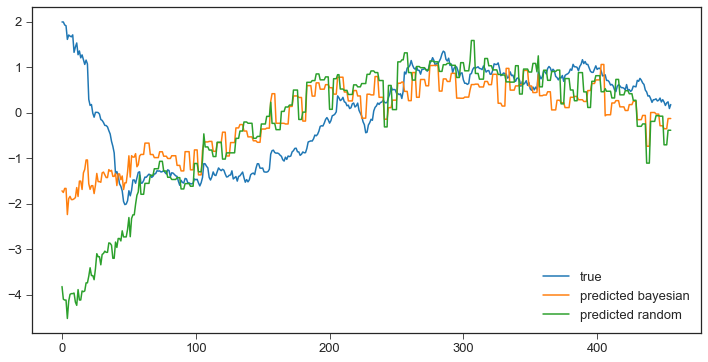

RMS = 0.923


In [32]:
model = MLPRegressor(random_state=42, learning_rate = 'adaptive', solver='adam', early_stopping=True,
                         learning_rate_init=BayesianOptimization.max["params"]["learning_rate_init"],
                         hidden_layer_sizes = (int(BayesianOptimization.max["params"]["nodes_1"]), 
                                               int(BayesianOptimization.max["params"]["nodes_2"]))
                    )
model.fit(X_train, y_train)

# make predictions for test data
y_pred_mlp = model.predict(X_test)

# evaluate predictions
plt.figure(figsize=(12,6))
plt.plot(y_test,label="true")
plt.plot(y_pred_mlp, label="predicted bayesian")
plt.plot(y_pred, label="predicted random")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred_mlp)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

## Linear Regression

In [33]:
reg = LinearRegression().fit(X_train, y_train)
y_pred_linear = reg.predict(X_test)

In [34]:
LSTM_res = np.loadtxt("LSTM_predicted_5.txt")

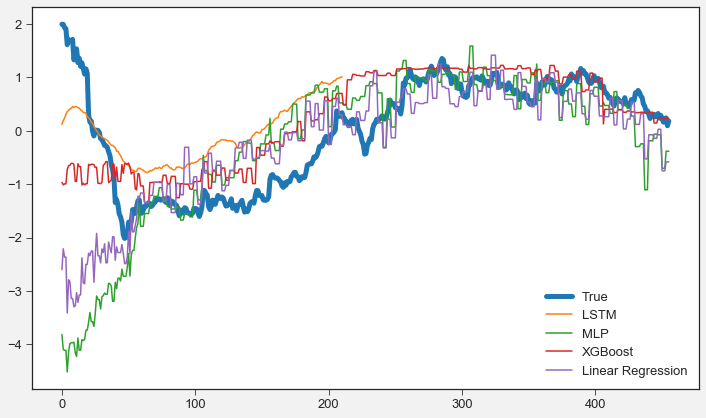

In [35]:
fig = plt.figure(figsize=(10,6))
plt.plot(y_test, label="True", lw=5.)
plt.plot(LSTM_res,label="LSTM")
plt.plot(y_pred, label="MLP")
plt.plot(y_pred_xg, label="XGBoost")
plt.plot(y_pred_linear, label="Linear Regression")
fig.patch.set_facecolor("#f2f2f2")
plt.legend()
plt.tight_layout()
plt.show()

if save:
    fig.savefig(f"figs/Final_result_test_on_{test_on}.png", dpi=500, facecolor=fig.get_facecolor())